In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
from lesanalysis import *

### Set root directory and case name

In [2]:
casename = 'MSM97-LT'
palmdata_root = '/Users/qingli/data/palm'
inputfile_dir = palmdata_root+'/'+casename

### Read profile data

In [3]:
inputfile_pfl   = inputfile_dir+'/DATA_1D_PR_NETCDF'
data_pfl   = PALMData1DPR(inputfile_pfl)

### Plot profiles

- Parameters

In [4]:
# Gravitational acceleration (m/s^2)
g = 9.81
# Latitude
lat = 45
# Coriolis parameter (1/s)
f = 4*np.pi/86400*np.sin(lat/180*np.pi)
# friction velocity (m/s)
ustar = 6.1e-3
# surface temperature flux (K m/s)
Q0 = 1.19e-6
# reference density
rho_0 = 1027.0
# range of z/h_b
ymin = -1.6
ymax = 0

- Time

In [5]:
time = data_pfl.dataset.variables['time'][:]
deltat = 2*np.pi/f # one inertial period
ttarget = time[-1]-deltat
tidx_start = np.argmin(np.abs(time-ttarget))
tidx_end = -1

- Initial temperature and salinity profiles

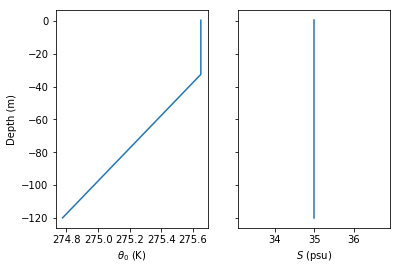

In [6]:
# starting and ending indices
fig, axarr = plt.subplots(1, 2, sharey='row')
data_pfl.read_profile('pt', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[0], xlabel=r'$\theta_0$ (K)', ylabel='Depth (m)')
data_pfl.read_profile('sa', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[1], xlabel=r'$S$ (psu)', ylabel='off')


- Mean boundary layer depth defined by the depth where N^2 reaches maximum

h_b =  43.38 m


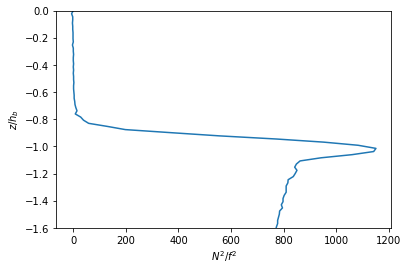

In [7]:
prho = data_pfl.read_profile('prho', tidx_start=tidx_start, tidx_end=tidx_end)
NN_data = -g*(prho.data[:,1:]-prho.data[:,0:-1])/(prho.z[1:]-prho.z[0:-1])/rho_0
NN_z = 0.5*(prho.z[1:]+prho.z[0:-1])
NN = LESProfile(data=NN_data, data_name=r'$N^2$', data_units=r's$^{-2}$', z=NN_z, time=time[tidx_start:tidx_end])
zidx = np.argmax(NN.data, axis=1)
hb = np.abs(NN.z[zidx].mean())
print('h_b = {:6.2f} m'.format(hb))
norm = 1/f**2
znorm = 1/hb
NN.plot_mean(norm=norm, znorm=znorm, xlabel=r'$N^2/f^2$',ylabel=r'$z/h_b$', ylim=[ymin, ymax])

- Mean velocity

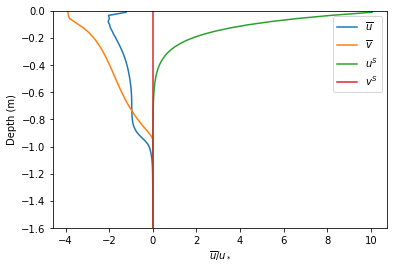

In [8]:
norm = 1/ustar
znorm = 1/hb
data_pfl.read_profile('u', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel=r'$\overline{u}/u_*$',
                             ylabel='Depth (m)', ylim=[ymin, ymax], label='$\overline{u}$')
data_pfl.read_profile('v', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel='off', ylabel='off', label='$\overline{v}$')
try:
    data_pfl.read_profile('u_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel='off', ylabel='off', label='$u^S$')
    data_pfl.read_profile('v_stk', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel='off', ylabel='off', label='$v^S$')
except ValueError:
    print('Stokes drift not found. Skip.')
    
plt.legend()

- Momentum fluxes

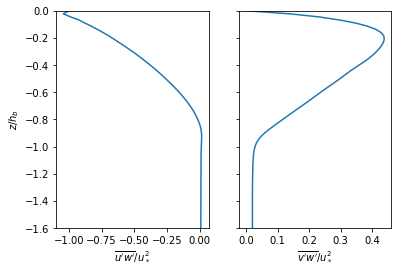

In [9]:
# normalizaing factor
norm = 1/ustar**2
znorm = 1/hb
# subplots
fig, axarr = plt.subplots(1, 2, sharey='row')
data_pfl.read_profile('wu', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                            axis=axarr[0], norm=norm, znorm=znorm,
                            xlabel=r'$\overline{u^\prime w^\prime}/u_*^2$',
                            ylabel=r'$z/h_b$', ylim=[ymin, ymax])
data_pfl.read_profile('wv', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                            axis=axarr[1], norm=norm, znorm=znorm, 
                            xlabel=r'$\overline{v^\prime w^\prime}/u_*^2$', ylabel='off')


- Velocity variance

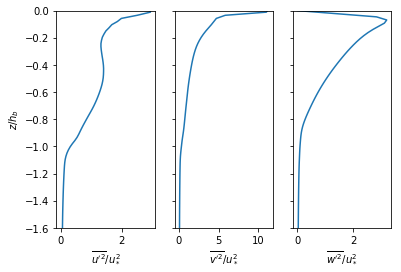

In [10]:
# normalizing factor
norm = 1/ustar**2
znorm = 1/hb
# subplots
fig, axarr = plt.subplots(1, 3, sharey='row')
# lower right panel
data_pfl.read_profile('u*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[0], norm=norm, znorm=znorm,
                             xlabel=r'$\overline{{u^\prime}^2}/u_*^2$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax])
data_pfl.read_profile('v*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[1], norm=norm, znorm=znorm,
                             xlabel=r'$\overline{{v^\prime}^2}/u_*^2$', ylabel='off')
data_pfl.read_profile('w*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             axis=axarr[2], norm=norm, znorm=znorm,
                             xlabel=r'$\overline{{w^\prime}^2}/u_*^2$', ylabel='off')

- TKE

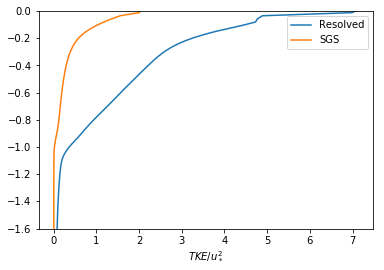

In [11]:
# normalizing factor
norm = 1/ustar**2
znorm = 1/hb
e_res = data_pfl.read_profile('e*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                              norm=norm, znorm=znorm, xlabel=r'$TKE/u_*^2$', ylabel='off',
                              ylim=[ymin, ymax], label='Resolved')
e_sgs = data_pfl.read_profile('e', tidx_start=tidx_start, tidx_end=tidx_end)
e_sgs.z[0] = np.nan # fix the invalid depth of e at the bottom
e_sgs.plot_mean(norm=norm, znorm=znorm, xlabel='off', ylabel='off', label='SGS')
plt.legend()

- Vertial velocity skewness

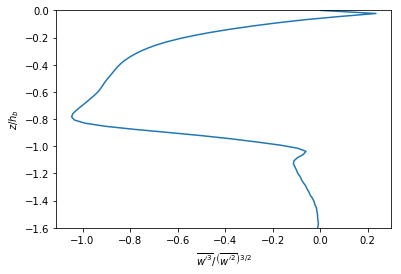

In [12]:
# normalizing factor
norm = 1
znorm = 1/hb
data_pfl.read_profile('Sw', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel=r'$\overline{{w^\prime}^3} / \left(\overline{{w^\prime}^2}\right)^{3/2}$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax])

- Temperature variance

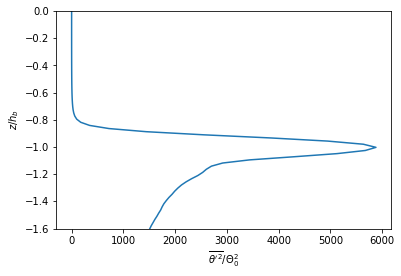

In [13]:
# normalizing factor
norm = 1/(Q0/ustar)**2
znorm = 1/hb
data_pfl.read_profile('pt*2', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel=r'$\overline{{\theta^\prime}^2}/\Theta_0^2$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax], label='Total')

- Temperature fluxes

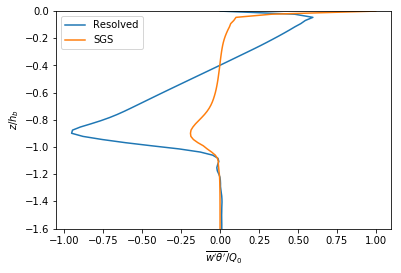

In [14]:
# normalizing factor
norm = 1/Q0
znorm = 1/hb
data_pfl.read_profile('w*pt*', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel=r'$\overline{w^\prime \theta^\prime}/Q_0$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax], label='Resolved')
data_pfl.read_profile('w"pt"', tidx_start=tidx_start, tidx_end=tidx_end).plot_mean(
                             norm=norm, znorm=znorm,
                             xlabel='off', ylabel='off', label='SGS')
plt.legend()
